In [1]:
import sys
import warnings
import math as m
import numpy as np
import pandas as pd
import tensorly as tl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import acf

import scipy
from scipy.linalg import hankel
from scipy.signal import find_peaks
from scipy.spatial import distance_matrix

import visuals

In [2]:
plt.rcParams['font.family'] = 'DejaVu Serif'

In [3]:
def delay_embedding_matrix(s, nlags):
    """Make a matrix with delay embeddings.

    Parameters
    ----------
    s : np.array
        The time series data.

    nlags : int
        Size of time lags.

    Returns
    -------
    delay_embedding_matrix : np.array of shape  (len(s) - lags + 1 , lags)
        Matrix with lags.
    """ 
    N = len(s)
    delay_embedding_matrix = hankel(s[ : N - nlags + 1], s[N - nlags : N])
    return delay_embedding_matrix

In [4]:
def prepare_time_series(path, centred = True):
    data = pd.read_csv(path, delimiter =';', decimal=',')
    
    time_series = data[['X_value', 'Y_value', 'Z_value']]
    
    if centred:
        time_series = (time_series - np.mean(time_series, axis = 0))/np.std(time_series, axis = 0)
        
    time_points = (data['time'].values).astype(float).reshape([-1,])
    time_points = np.linspace(0,time_points[-1]-time_points[0],time_series.shape[0])

    return time_series,time_points

In [63]:
path_basic_experiment = ['walk', 'stairs','bike', 'squats']
data_limits = [(7000,14000), (2300,7500), (14260,22548),  (4000,12000)]

C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


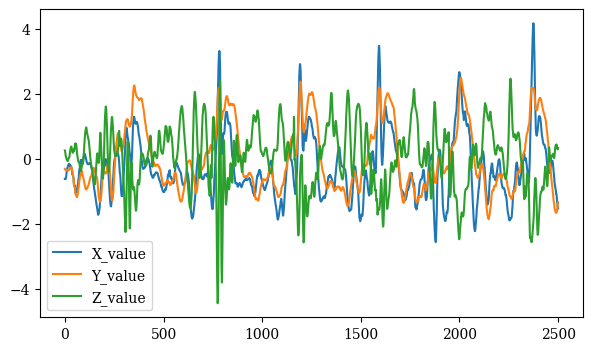

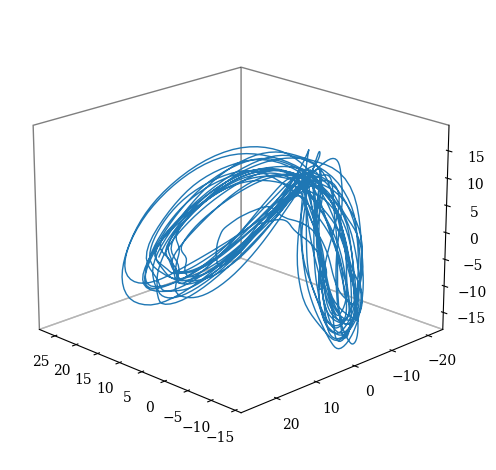

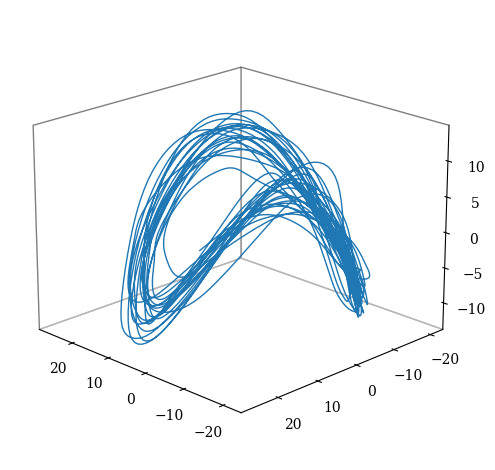

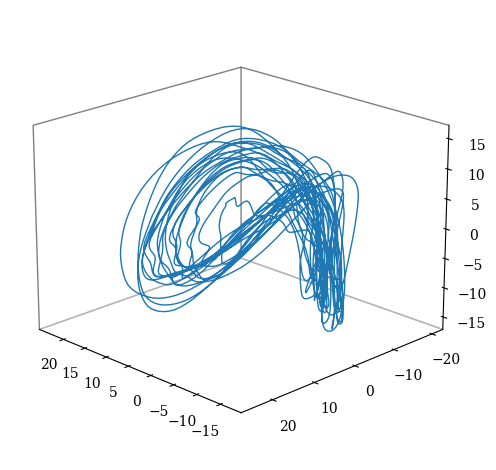

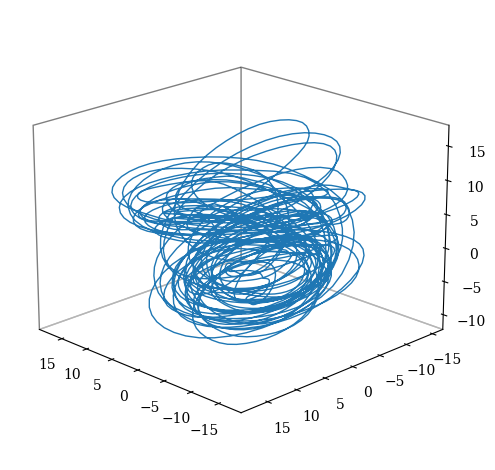

In [65]:
index_activity = 2
x_acc, t = prepare_time_series(f'./../data/basic_experiment_{path_basic_experiment[index_activity]}.csv', centred = True)
x_acc = x_acc[data_limits[index_activity][0]:data_limits[index_activity][1]:]
res = x_acc.reset_index(drop=True).loc[:2500].plot(figsize=(7,4)).get_figure()
res.savefig(f'./../slides/figs/init_time_series_{path_basic_experiment[index_activity]}.png')


S = np.array([
    delay_embedding_matrix(x_acc['X_value'].to_numpy(), 500),
    delay_embedding_matrix(x_acc['Y_value'].to_numpy(), 500),
    delay_embedding_matrix(x_acc['Z_value'].to_numpy(), 500)
])
for i, s in enumerate(S):
    visuals.plot_phase_trajectory(PCA(4).fit_transform(s)[::3,:3], path = f'./../slides/figs/phase_traj_{i}_PCA_{path_basic_experiment[index_activity]}.png')
s = delay_embedding_matrix((x_acc[['X_value','Y_value','Z_value']]**2).sum(axis=1)**0.5,500)
visuals.plot_phase_trajectory(PCA(4).fit_transform(s)[::3,:3])

In [66]:
# x_acc, t = prepare_time_series(f'./../data/basic_experiment_{path_basic_experiment[index_activity]}.csv', centred = True)
# x_acc = x_acc[data_limits[index_activity][0]:data_limits[index_activity][1]:]
# x_acc.loc[:].plot(figsize=(16,4))
# S = np.array([
#     delay_embedding_matrix(x_acc['X_value'].to_numpy(), 10),
#     delay_embedding_matrix(x_acc['Y_value'].to_numpy(), 10),
#     delay_embedding_matrix(x_acc['Z_value'].to_numpy(), 10)
# ])
# for s in S:
#     visuals.plot_phase_trajectory(PCA(4).fit_transform(s)[::,:3])

In [67]:
A_0 = tl.random.random_tensor((10, 10, 10, 3))

In [9]:
tl.tenalg.outer([S[n,0,:] for n in range(S.shape[0])]).shape

(500, 500, 500)

In [10]:
# tl.tenalg.multi_mode_dot(A_0, [S[n,0,:] for n in range(S.shape[0])])

In [11]:
# tl.tenalg.inner(tl.tenalg.outer([S[n,0,:] for n in range(S.shape[0])]), A_0, n_modes = 3)

In [12]:
# tensor_A_0, modes_A_0

In [13]:
global_iter = 0

In [14]:
40* 40* 40* 3

192000

In [15]:
def func(A, shape = (40, 40, 40, 3), S = S):
    global global_iter
    global_iter+=1
    if global_iter %1000 == 0: print('|', end='')
    ################################################
    ## Make a dynamic tensor A #####################
    A = A.reshape(shape)
    ################################################
    ## Make a subspace #############################
    X_p = []
    for i in range(S.shape[1]):
        X_p.append(tl.tenalg.multi_mode_dot(A, [S[n,i,:] for n in range(S.shape[0])]))
    X_p = np.array(X_p)
    ################################################
    ## Precalc a tensor with low dim vectors #######
    list_A_S = [tl.tenalg.mode_dot(A, vec, mode=S.shape[0])  for vec in X_p]
    ################################################
    ## Calc mse among initial time series ##########
    list_S_hat = []
    mse_error = 0
    for dim_index in range(S.shape[0]):
        modes_all = np.arange(S.shape[0])
        modes = np.delete(modes_all, dim_index, axis=0).astype(int).tolist()
        
        S_hat = []
        for time_index in range(S.shape[1]):
            S_hat.append(tl.tenalg.multi_mode_dot(list_A_S[time_index], [S[n,i,:] for n in modes], modes = modes))
        S_hat = np.array(S_hat)
    
        mse_error += np.mean((S[dim_index]-S_hat)**2)**0.5
    return mse_error

In [16]:
from scipy.optimize import minimize

In [17]:
# res = minimize(func, A_0.reshape(-1,), options = {'maxiter':1000, 'adaptive':True})

In [18]:
# X_p = []
# for i in range(S.shape[1]):
#     X_p.append(tl.tenalg.multi_mode_dot(res['x'].reshape((10, 10, 10, 3)), [S[n,i,:] for n in range(S.shape[0])]))
# X_p = np.array(X_p)

In [19]:
# visuals.plot_phase_trajectory(X_p)

In [20]:
import torch
from torch import nn, optim
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [21]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [22]:
print('Pytorch CUDA Version is', torch.version.cuda)

Pytorch CUDA Version is 11.8


In [73]:
index_activity = 3
shape_dims = [9, 3]

In [74]:
# x_acc, t = prepare_time_series(f'./../data/basic_experiment_{path_basic_experiment[index_activity]}.csv', centred = True)

In [75]:
data_limits

[(7000, 14000), (2300, 7500), (14260, 22548), (4000, 12000)]

In [76]:
x_acc

,X_value,Y_value,Z_value
14260,-0.614136,-0.309994,0.258822
14261,-0.613221,-0.312585,0.239914
14262,-0.618700,-0.319060,0.192088
14263,-0.625090,-0.332658,0.159833
14264,-0.617785,-0.349495,0.110891
...,...,...,...
22543,-0.047138,-0.084650,-0.098213
22544,-0.086391,-0.108610,-0.080416
22545,-0.110125,-0.117027,-0.097098
22546,-0.125643,-0.126739,-0.111560


In [77]:
x_acc, t = prepare_time_series(f'./../data/basic_experiment_{path_basic_experiment[index_activity]}.csv', centred = True)
x_acc = x_acc[data_limits[index_activity][0]:data_limits[index_activity][1]:]
# x_acc = x_acc[data_limits[index_activity][0]:data_limits[index_activity][1]+50_000:]
# S = np.array([
#     delay_embedding_matrix(x_acc['X_value'].to_numpy(), shape_dims[0]),
#     delay_embedding_matrix(x_acc['Y_value'].to_numpy(), shape_dims[0]),
#     delay_embedding_matrix(x_acc['Z_value'].to_numpy(), shape_dims[0])
# ])

S = np.array([
    PCA(shape_dims[0]).fit_transform(delay_embedding_matrix(x_acc['X_value'].to_numpy(), 500)),
    PCA(shape_dims[0]).fit_transform(delay_embedding_matrix(x_acc['Y_value'].to_numpy(), 500)),
    PCA(shape_dims[0]).fit_transform(delay_embedding_matrix(x_acc['Z_value'].to_numpy(), 500))
])

################################################
## Make a subspace #############################
X_p = []
for i in range(S.shape[1]):
    X_p.append(tl.tenalg.outer([S[n,i,:] for n in range(S.shape[0])]).reshape(-1,))
X_p = np.array(X_p)

In [78]:
X_p.shape

(7501, 729)

In [79]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.from_numpy(X_p).to(device)

In [80]:
class Autoencoder(nn.Module):
    def __init__(self, in_shape, enc_shape):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_shape, enc_shape, dtype=float))
        
    def forward(self, x):
        x = nn.functional.linear(x, self.weight.T)
        x = nn.functional.linear(x, self.weight)
        return x

In [81]:
encoder = Autoencoder(in_shape=shape_dims[0]**3, enc_shape=shape_dims[1]).double().to(device)

error = nn.MSELoss()

optimizer = optim.Adam(encoder.parameters())

In [82]:
def train(model, error, optimizer, n_epochs, x):
    model.train()
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        output = model(x)
        loss = error(output, x)
        loss.backward()
        optimizer.step()
        
        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

In [83]:
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0

In [84]:
%%time
train(encoder, error, optimizer, 40000, x)

epoch 4000 	 Loss: 5.188e+04
epoch 8000 	 Loss: 1.181e+04
epoch 12000 	 Loss: 9473
epoch 16000 	 Loss: 9290
epoch 20000 	 Loss: 9277
epoch 24000 	 Loss: 9276
epoch 28000 	 Loss: 9276
epoch 32000 	 Loss: 9276
epoch 36000 	 Loss: 9276
epoch 40000 	 Loss: 7067
CPU times: total: 24.6 s
Wall time: 2min 19s


In [85]:
with torch.no_grad():
    encoded = nn.functional.linear(x, encoder.weight.T)
    enc = encoded.cpu().detach().numpy()

In [86]:
# with torch.no_grad():
#     encoded = encoder.encode(x)
#     decoded = encoder.decode(encoded)
#     mse = error(decoded, x).item()
#     enc = encoded.cpu().detach().numpy()
#     dec = decoded.cpu().detach().numpy()

C:\Users\mtikh\OneDrive\Desktop\projects\TensorDynamic\code\visuals.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


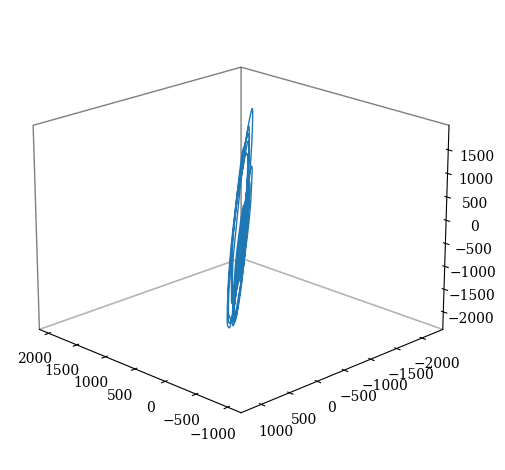

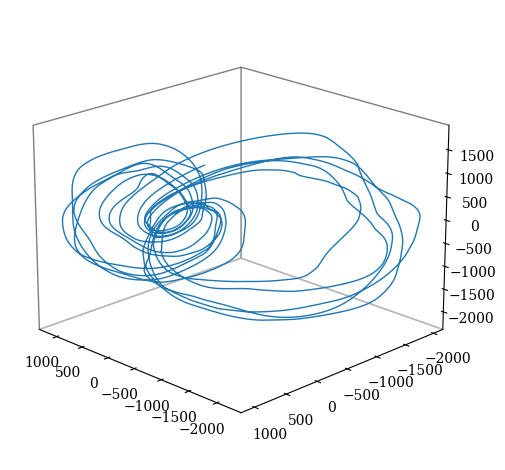

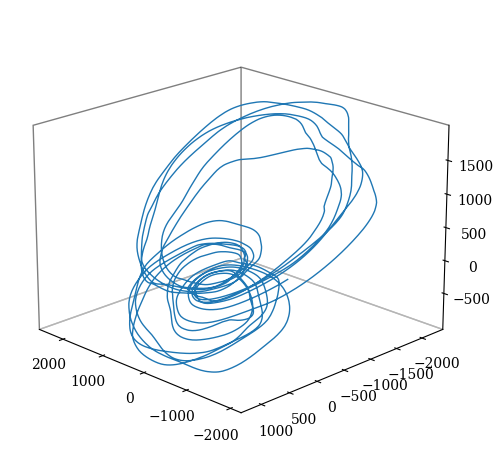

In [87]:
visuals.plot_phase_trajectory(enc[:4000], rotation = (0,0, 0), path = f'./../slides/figs/3_phase_traj_tensor_{path_basic_experiment[index_activity]}_1.png')
visuals.plot_phase_trajectory(enc[:4000], rotation = (0,90,0), path = f'./../slides/figs/3_phase_traj_tensor_{path_basic_experiment[index_activity]}_2.png')
visuals.plot_phase_trajectory(enc[:4000], rotation = (0,0, 90), path = f'./../slides/figs/3_phase_traj_tensor_{path_basic_experiment[index_activity]}_3.png')

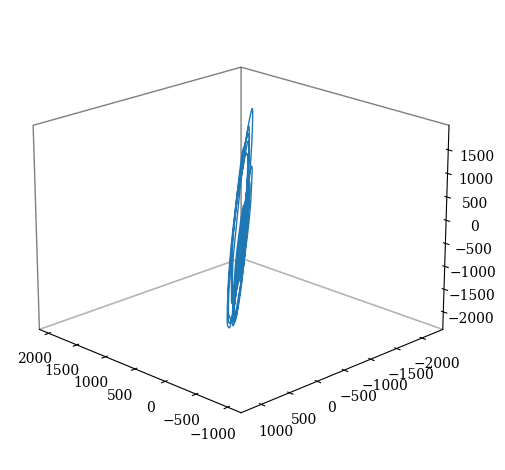

In [88]:
visuals.plot_phase_trajectory(enc[:4000], path = f'./../slides/figs/3_phase_traj_tensor_{path_basic_experiment[index_activity]}_2.png')